My idea is breaking each strong node to multiple nodes!

source: https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX

# hide

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [5]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 25.1 MB/s 
     |████████████████████████████████| 3.5 MB 26.8 MB/s 


In [6]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

## Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [77]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

datasetnames = ['PubMed','Cora','CiteSeer']
datasetname = datasetnames[2] 
dataset = Planetoid(root='data/Planetoid', name=datasetname, transform=NormalizeFeatures())
# dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Hide now, Test

In [78]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [79]:
try:
    log['dataset']=dataset
except:
    log = {}
    log['dataset']=dataset

In [80]:
nodes = np.zeros(len(data.x))

In [81]:
for i in range(len(data.edge_index[0])):
    a =  data.edge_index[0][i]
    b =  data.edge_index[1][i]
    nodes[a]+=1
    nodes[b]+=1

In [82]:
max(nodes)

198.0

In [83]:
original_nodes = np.copy(nodes)

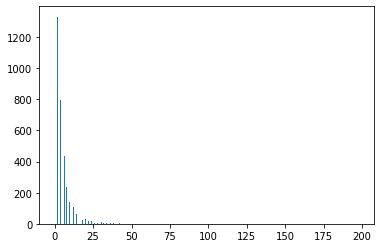

In [84]:
_ = plt.hist(nodes, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [85]:
nodes2 = nodes[nodes>50]
len(nodes2)

8

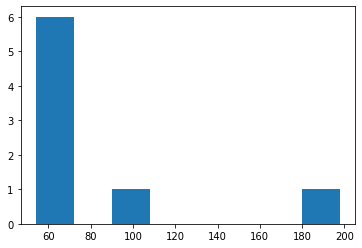

In [86]:
_ = plt.hist(nodes2, bins='auto')  # arguments are passed to np.histogram
plt.show()

I guess break each extra 100 to a new part

In [87]:
data = dataset[0]

In [88]:
log['raw data'] = str(data)

In [89]:
x = data.x
ei = data.edge_index 
y = data.y
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

In [90]:
def multiappender(l,e):
    d = e.reshape(1,-1)
    l = torch.cat([l, torch.tensor(d)], dim=0)
    return l

In [91]:
def appender(l,e):
    z = torch.cat([l, torch.tensor(e).reshape(1)], dim=0)
    return z

In [92]:
# log['info'] = {}
# log['info']['#of(edge_index,x,ei,train_mask']=[len(data.edge_index[0]),len(data.x),len(ei),len(train_mask)]

## run phase 1

save original data:

In [93]:
class CGraph:

	# init function to declare class variables
	def __init__(self, V):
		self.V = V
		self.adj = [[] for i in range(V)]

	def DFSUtil(self, temp, v, visited):

		# Mark the current vertex as visited
		visited[v] = True

		# Store the vertex to list
		temp.append(v)

		# Repeat for all vertices adjacent
		# to this vertex v
		for i in self.adj[v]:
			if visited[i] == False:

				# Update the list
				temp = self.DFSUtil(temp, i, visited)
		return temp

	# method to add an undirected edge
	def addEdge(self, v, w):
		self.adj[v].append(w)
		self.adj[w].append(v)

	# Method to retrieve connected components
	# in an undirected graph
	def connectedComponents(self):
		visited = []
		cc = []
		for i in range(self.V):
			visited.append(False)
		for v in range(self.V):
			if visited[v] == False:
				temp = []
				cc.append(self.DFSUtil(temp, v, visited))
		return cc

In [94]:
def findcomponents(data):
    
    x = data.x
    ei = data.edge_index

    cg = CGraph(len(x))

    for i in tqdm(range(len(ei[0]))):
        cg.addEdge(ei[0][i],ei[1][i])
        cg.addEdge(ei[1][i],ei[0][i])


    cc = cg.connectedComponents()
   
    return cc

In [95]:
def insertnoise(data,noiseratio):
    x = data.x
    ei = data.edge_index 
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

    cc = findcomponents(data)
    
    lennoise = int(len(ei[0]) * noiseratio)
    for i in range(lennoise):
        n1 = random.choice(random.choice(cc))
        n2 = random.choice(random.choice(cc))
        e = np.array([n1,n2])
        d = e.reshape(-1,1)
        ei = torch.cat([ei, torch.tensor(d)], dim=1)      


    data.x = x
    data.edge_index = ei 
    data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask
    return data

In [96]:
def make_data_ready(flag_type_2,
                    each_part_size,
                    istype2 = False,
                    noiseratio = 0.001):
    
    dataset = Planetoid(root='data/Planetoid', name=datasetname, transform=NormalizeFeatures())
    data = dataset[0]
    
    redunclass = [[i] for i in range(len(data.x))]

    nodes = np.zeros(len(data.x))


    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1
    

    strongs = []
    for i in range(len(nodes)):
        if nodes[i]>each_part_size:
            strongs.append(i)
    
    if noiseratio>0:
        data = insertnoise(data,noiseratio)
    
    x = data.x
    ei = data.edge_index 
    y = data.y
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

    d = False  

    for s in strongs:
        n = nodes[s]
        while(n>each_part_size):

            x = multiappender(x,x[s])

            redunclass[s].append(len(x)-1)
            y = appender(y,y[s])

            train_mask = appender(train_mask,train_mask[s])
            val_mask = appender(val_mask,val_mask[s]) 
            
            if istype2:
                test_mask = appender(test_mask,False)
                test_mask[s] = False
            else:
                test_mask = appender(test_mask,test_mask[s])
            
            if n >= each_part_size*1.5:
                t = each_part_size
                n-=t
                
                for i in range(len(ei[0])):
                    e1,e2 = ei[0][i],ei[1][i]
                    
                    if t<=0:
                        break

                    if e1==s:
                        t-=1
                        ei[0][i] = len(x)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(x)-1
                    
            else:
                t = int((n+1)/2)
                n-=t
                
                for i in range(len(ei[0])):
                    if t<=0:
                        break

                    e1,e2 = ei[0][i],ei[1][i]
                    if e1==s:
                        t-=1
                        ei[0][i] = len(x)-1
                    elif e2==s:
                        t-=1
                        ei[1][i] = len(x)-1
                    
            if flag_type_2:

                d = torch.tensor([len(x)-1,s])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)

                d = torch.tensor([s,len(x)-1])
                d = d.reshape(2,-1)
                ei = torch.cat([ei, torch.tensor(d)], dim=-1)
    
    data.x = x
    data.edge_index = ei 
    data.y = y
    data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask

    nodes = np.zeros(len(data.x))
    for i in range(len(data.edge_index[0])):
        a =  data.edge_index[0][i]
        b =  data.edge_index[1][i]
        nodes[a]+=1
        nodes[b]+=1

    return x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass

In [97]:
# x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = True,
#                                                                                        each_part_size = 100,
#                                                                                        istype2 = False)


# _ = plt.hist(nodes, bins='auto')  # arguments are passed to np.histogram
# plt.show()

Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

# models running:

In [98]:
isfirst = True
if isfirst:
    log = {}
    log['dataset']=datasetname
    isfirst = False

In [105]:
index = len(log.keys())

each_part_size = 50
flag_type_2 = False
istype2 = False
noiseratio = 0
maxepoch = 101

log['test'+str(index)] = {}
log['test'+str(index)]['each_part_size'] = each_part_size
log['test'+str(index)]['flag type 2'] = flag_type_2
log['test'+str(index)]['istype2'] = istype2
log['test'+str(index)]['noiseratio'] = noiseratio

x,ei,y,d,strongs,nodes,data,train_mask,test_mask,val_mask,dataset,redunclass = make_data_ready(flag_type_2 = flag_type_2,
                                                                                       each_part_size = each_part_size,
                                                                                       istype2 = istype2,
                                                                                       noiseratio = noiseratio) #flag_type_2 is connecting breaked nodes and istype2 means avoid breaked nodes in test 

###hide

In [106]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))


#######
##MLP##
#######
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def mlp_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def mlp_test(model,data):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def mlp_test2(model,data):
    model.eval()
    out = model(data.x)

    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc

    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)

    return acc1,acc2,acc3

for epoch in range(1, maxepoch):
    loss,model = mlp_train(model,data)
    if epoch%20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print('\n')
acc1,acc2,acc3 = mlp_test2(model,data)
log['test'+str(index)]['mlp'] = {}
log['test'+str(index)]['mlp']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['mlp']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['mlp']['acc3']=f'{acc3:.4f}'


#######
##GNN##
#######

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

# model.eval()
# out = model(data.x, data.edge_index)
# visualize(out, color=data.y)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def gnn_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gnn_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc

    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)
    return acc1,acc2,acc3

for epoch in range(1, maxepoch):
    loss,model = gnn_train(model,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print("\n")
acc1,acc2,acc3 = gnn_test2(model,data)

log['test'+str(index)]['gnn1'] = {}
log['test'+str(index)]['gnn1']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['gnn1']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['gnn1']['acc3']=f'{acc3:.4f}'

# model.eval()
# out = model(data.x, data.edge_index)
# visualize(out, color=data.y)


########
##GNN2##
########

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        # self.conv1 = GATConv(...)  # TODO
        # self.conv2 = GATConv(...)  # TODO
        # down:
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)  
        self.conv2 = GATConv(hidden_channels, hidden_channels) 
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn2_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model


def gnn2_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def gnn2_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc

    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc2 = true3/len(redunclass)
    return acc1,acc2,acc3

for epoch in range(1, maxepoch):
    loss,model = gnn2_train(model,data)
    # val_acc = gnn2_test(data.val_mask)
    test_acc = gnn2_test(model,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')

print('\n')
acc1,acc2,acc3 = gnn_test2(model,data)

log['test'+str(index)]['gnn2'] = {}
log['test'+str(index)]['gnn2']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['gnn2']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['gnn2']['acc3']=f'{acc3:.4f}'

##############
##semi#light##
##############

class GCN_semi_light(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

model = GCN_semi_light(hidden_channels=16)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gnn_train(model,data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,model

def gnn_test(model,data):
      model.eval()
      out = model(data.x, data.edge_index)
      
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def semi_gnn_test2(model,data):
    model.eval()
    out = model(data.x, data.edge_index)

    #   true1 = 0
    true2 = 0
    true3 = 0

    acc1 = -1
    acc2 = -1
    acc3 = -1

    #acc1: simple format
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc1 =  test_acc

    #acc2: weighted_avg_arg_max:
    for clas in redunclass:
        a = out[clas[0]]
        for clasi in clas[1:]:
            a += out[clasi]
        pred = a.argmax()
        if pred == data.y[clas[0]]:
            true2 += 1
    acc2 = true2/len(redunclass)

    #acc3: voting:
    for clas in redunclass:
        votes = np.zeros(9)
        
        for clasi in clas:
            a = out[clasi]
            votes[a.argmax()]+=1
        pred = votes.argmax()
        if pred == data.y[clas[0]]:
            true3 += 1
    acc3 = true3/len(redunclass)

    return acc1,acc2,acc3

for epoch in range(1, maxepoch):
    loss,model = gnn_train(model,data)
    if epoch%20==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


acc1,acc2,acc3 = semi_gnn_test2(model,data)

log['test'+str(index)]['semi gnn'] = {}
log['test'+str(index)]['semi gnn']['acc1']=f'{acc1:.4f}'
log['test'+str(index)]['semi gnn']['acc2']=f'{acc2:.4f}'
log['test'+str(index)]['semi gnn']['acc3']=f'{acc3:.4f}'

<IPython.core.display.Javascript object>

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)
Epoch: 020, Loss: 1.5973
Epoch: 040, Loss: 1.2095
Epoch: 060, Loss: 0.8223
Epoch: 080, Loss: 0.6115
Epoch: 100, Loss: 0.6487


GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)
Epoch: 020, Loss: 1.5970
Epoch: 040, Loss: 1.2693
Epoch: 060, Loss: 0.9667
Epoch: 080, Loss: 0.8014
Epoch: 100, Loss: 0.6462


GAT(
  (conv1): GCNConv(3703, 16)
  (conv2): GATConv(16, 16, heads=1)
  (conv3): GCNConv(16, 6)
)
Epoch: 020, Loss: 1.6309, Test: 0.5445
Epoch: 040, Loss: 1.2550, Test: 0.6434
Epoch: 060, Loss: 0.8317, Test: 0.6474
Epoch: 080, Loss: 0.5805, Test: 0.6474
Epoch: 100, Loss: 0.4643, Test: 0.6513


GCN_semi_light(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)
Epoch: 020, Loss: 1.4766
Epoch: 040, Loss: 1.0599
Epoch: 060, Loss: 0.7400
Epoch: 080, Loss: 0.5618
Epoch: 100, Loss: 0.4597


#logs:

In [107]:
log

{'dataset': 'CiteSeer',
 'test1': {'each_part_size': 1000,
  'flag type 2': False,
  'istype2': False,
  'noiseratio': 0,
  'mlp': {'acc1': '0.5720', 'acc2': '0.5669', 'acc3': '0.5669'},
  'gnn1': {'acc1': '0.7140', 'acc2': '0.7039', 'acc3': '0.7039'},
  'gnn2': {'acc1': '0.6580', 'acc2': '0.6429', 'acc3': '0.6429'},
  'semi gnn': {'acc1': '0.7040', 'acc2': '0.6958', 'acc3': '0.6958'}},
 'test2': {'each_part_size': 100,
  'flag type 2': False,
  'istype2': False,
  'noiseratio': 0,
  'mlp': {'acc1': '0.5590', 'acc2': '0.5624', 'acc3': '0.5624'},
  'gnn1': {'acc1': '0.7200', 'acc2': '0.7060', 'acc3': '0.7060'},
  'gnn2': {'acc1': '0.6540', 'acc2': '0.6396', 'acc3': '0.6396'},
  'semi gnn': {'acc1': '0.7050', 'acc2': '0.6937', 'acc3': '0.6937'}},
 'test3': {'each_part_size': 50,
  'flag type 2': False,
  'istype2': False,
  'noiseratio': 0,
  'mlp': {'acc1': '0.5584', 'acc2': '0.5597', 'acc3': '0.5597'},
  'gnn1': {'acc1': '0.7143', 'acc2': '0.7024', 'acc3': '0.7024'},
  'gnn2': {'acc1':